<a href="https://colab.research.google.com/github/bmijangos/ProyectoIntegrador/blob/main/Avance2_Equipo21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Tecnológico de Monterrey**

# **Proyecto Integrador**
## Avance 2
## Ingeniería de características
###Dra. Grettel Barceló Alonso
###EQUIPO 21
###Bernardo Mijango Flores - A01793654
###Dalia Isabel López Tapia - A01245026
###David Valles Canedo - A01191310
12 de mayo de 2024

### Importaciones, Funciones, Dependencias y Pasos Iniciales

In [12]:
# conectamos al drive de google para la lectura de los archivos csv
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:

!pip install feature_engine


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.3/344.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 54.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 2.2.2 which is incompatible.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 2.2.2 which is incompatible.


In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns   # para un mejor despliegue de los gráficos

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.outliers import OutlierTrimmer


In [8]:
# función para mostrar un diagrama de caja encima de un histograma
def plot_boxplot_hist(data, variable):
  f,(ax_box, ax_hist) = plt.subplots(2,
                                     sharex=True,
                                     gridspec_kw={"height_ratios":(0.50,0.85)})
  sns.boxplot(x=data[variable],ax=ax_box)
  sns.histplot(data=data, x=variable, ax=ax_hist)
  ax_box.set(xlabel="")
  plt.title(variable)
  plt.show()


In [9]:
# función para encontrar los límites de una distribución variable usando la regla de proximidad del rango intercuartil:

def find_limits(df,variable,fold):
  IQR = df[variable].quantile(0.75)-df[variable].quantile(0.25)
  lower_limit = df[variable].quantile(0.25)-(IQR * fold)
  upper_limit = df[variable].quantile(0.75)+(IQR * fold)
  return lower_limit, upper_limit

Se realizo una corrección en la consulta de la base de datos para obtener la edad del cliente al momento del desembolso del crédito, en el avance 1 nos dimos cuenta de este error, además se agregaron los castigos en el mismo archivo dando un total de 4,382,214 registros resultado de los 4,254,537 del archivo de pagos mas 127,677 del archivo de castigos

In [13]:
# Lectura de los archivos csv
file_path = '/content/drive/MyDrive/DataSetProyecto/GrupalTodoCorregido.csv'

label = ["IdCliente","FechaAltaCliente","CodigoGrupo","EdadCliente","Genero","EstadoCivil","Escolaridad","CapacidadPago","Localidad","CodigoSucursal","CodigoASesor","NumeroCredito","CicloCliente","FechaDesembolso","FechaVencimiento","FechaCancelacion","Plazo","PeriodoPago","EstatusCredito","MontoCredito","CuotaNumero","CuotaFechaVencimiento","CuotaFechaCancelacion","MontoCuota","MontoCapital","SaldoCapital","EstatusCuota","DiasAtraso"]

# Obtenemos el dataframe
grupal_df = pd.read_csv(file_path, names=label)

grupal_df.shape

(4382214, 28)

In [14]:
grupal_df.isnull().sum()

IdCliente                   0
FechaAltaCliente            0
CodigoGrupo                 0
EdadCliente                 0
Genero                      0
EstadoCivil                 0
Escolaridad              1243
CapacidadPago               0
Localidad                   0
CodigoSucursal              0
CodigoASesor                0
NumeroCredito               0
CicloCliente                0
FechaDesembolso             0
FechaVencimiento            0
FechaCancelacion            0
Plazo                       0
PeriodoPago                 0
EstatusCredito              0
MontoCredito                0
CuotaNumero                 0
CuotaFechaVencimiento       0
CuotaFechaCancelacion     128
MontoCuota                  0
MontoCapital                0
SaldoCapital                0
EstatusCuota                0
DiasAtraso                128
dtype: int64

Text(0.5, 1.0, 'Proporcion de datos faltantes por variable')

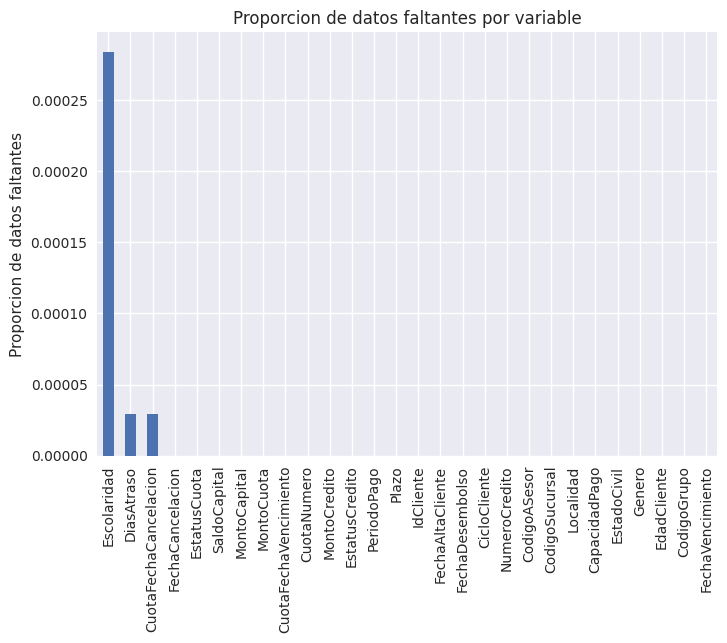

In [6]:
# visualizamos la proporcion de los datos faltantes

with plt.style.context("seaborn"):
  grupal_df.isnull().mean().sort_values(ascending=False).plot.bar(rot=90)

plt.ylabel("Proporcion de datos faltantes")
plt.title("Proporcion de datos faltantes por variable")


Al ser un procentaje menor al 0.028 % se decide eliminarlos de la muestra

In [15]:
# eliminamos los valores nulos
gpdf = grupal_df.dropna()

In [16]:
gpdf.isnull().values.any()

False

In [9]:
gpdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4380844 entries, 0 to 4382213
Data columns (total 28 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   IdCliente              int64  
 1   FechaAltaCliente       object 
 2   CodigoGrupo            int64  
 3   EdadCliente            int64  
 4   Genero                 object 
 5   EstadoCivil            int64  
 6   Escolaridad            object 
 7   CapacidadPago          float64
 8   Localidad              int64  
 9   CodigoSucursal         int64  
 10  CodigoASesor           object 
 11  NumeroCredito          int64  
 12  CicloCliente           int64  
 13  FechaDesembolso        object 
 14  FechaVencimiento       object 
 15  FechaCancelacion       object 
 16  Plazo                  int64  
 17  PeriodoPago            object 
 18  EstatusCredito         object 
 19  MontoCredito           float64
 20  CuotaNumero            int64  
 21  CuotaFechaVencimiento  object 
 22  CuotaFechaCancelacion  

In [10]:
gpdf.shape

(4380844, 28)

In [11]:
print(gpdf.describe(exclude=[object]))

          IdCliente   CodigoGrupo   EdadCliente   EstadoCivil  CapacidadPago  \
count  4.380844e+06  4.380844e+06  4.380844e+06  4.380844e+06   4.380844e+06   
mean   5.902005e+04  8.415457e+02  3.944503e+01  3.268472e+00   7.633413e+03   
std    3.836093e+04  5.770191e+02  1.305678e+01  1.669057e+00   3.069242e+04   
min    4.000000e+00  0.000000e+00  1.500000e+01  1.000000e+00  -6.391200e+06   
25%    2.367200e+04  3.130000e+02  2.900000e+01  2.000000e+00   2.400000e+03   
50%    5.530600e+04  8.230000e+02  3.800000e+01  3.000000e+00   6.000000e+03   
75%    9.229100e+04  1.244000e+03  4.800000e+01  5.000000e+00   1.017600e+04   
max    1.376940e+05  2.594000e+03  1.010000e+02  7.000000e+00   8.000400e+06   

          Localidad  CodigoSucursal  NumeroCredito  CicloCliente  \
count  4.380844e+06    4.380844e+06   4.380844e+06  4.380844e+06   
mean   7.607020e+03    6.142390e+00   6.143053e+09  5.265920e+00   
std    3.124029e+03    4.096959e+00   4.096748e+09  4.991101e+00   
min    

In [17]:
# Reemplazamos los valores negativos de la variable DiasAtraso por 0 ya que son pagos anticipados
gpdf.loc[gpdf['DiasAtraso'] < 1,'DiasAtraso'] = 0


In [18]:
print(gpdf.describe(include=[object]))

               FechaAltaCliente   Genero Escolaridad CodigoASesor  \
count                   4380844  4380844     4380844      4380844   
unique                    15962        2          14          528   
top     2004-02-05 00:00:00.000        F          1A       ACORZO   
freq                       7669  4378507     1302653        98613   

                FechaDesembolso         FechaVencimiento  \
count                   4380844                  4380844   
unique                     3268                     2816   
top     2013-04-30 00:00:00.000  2019-06-04 00:00:00.000   
freq                       6944                     4869   

               FechaCancelacion   PeriodoPago EstatusCredito  \
count                   4380844       4380844        4380844   
unique                     3303             3              2   
top     2015-12-08 00:00:00.000  CATORCENA(S)            CAN   
freq                       7115       3816897        4253254   

          CuotaFechaVencimiento 

In [14]:
print(gpdf.describe(exclude=[object]))

          IdCliente   CodigoGrupo   EdadCliente   EstadoCivil  CapacidadPago  \
count  4.380844e+06  4.380844e+06  4.380844e+06  4.380844e+06   4.380844e+06   
mean   5.902005e+04  8.415457e+02  3.944503e+01  3.268472e+00   7.633413e+03   
std    3.836093e+04  5.770191e+02  1.305678e+01  1.669057e+00   3.069242e+04   
min    4.000000e+00  0.000000e+00  1.500000e+01  1.000000e+00  -6.391200e+06   
25%    2.367200e+04  3.130000e+02  2.900000e+01  2.000000e+00   2.400000e+03   
50%    5.530600e+04  8.230000e+02  3.800000e+01  3.000000e+00   6.000000e+03   
75%    9.229100e+04  1.244000e+03  4.800000e+01  5.000000e+00   1.017600e+04   
max    1.376940e+05  2.594000e+03  1.010000e+02  7.000000e+00   8.000400e+06   

          Localidad  CodigoSucursal  NumeroCredito  CicloCliente  \
count  4.380844e+06    4.380844e+06   4.380844e+06  4.380844e+06   
mean   7.607020e+03    6.142390e+00   6.143053e+09  5.265920e+00   
std    3.124029e+03    4.096959e+00   4.096748e+09  4.991101e+00   
min    

In [19]:
gpdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4380844 entries, 0 to 4382213
Data columns (total 28 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   IdCliente              int64  
 1   FechaAltaCliente       object 
 2   CodigoGrupo            int64  
 3   EdadCliente            int64  
 4   Genero                 object 
 5   EstadoCivil            int64  
 6   Escolaridad            object 
 7   CapacidadPago          float64
 8   Localidad              int64  
 9   CodigoSucursal         int64  
 10  CodigoASesor           object 
 11  NumeroCredito          int64  
 12  CicloCliente           int64  
 13  FechaDesembolso        object 
 14  FechaVencimiento       object 
 15  FechaCancelacion       object 
 16  Plazo                  int64  
 17  PeriodoPago            object 
 18  EstatusCredito         object 
 19  MontoCredito           float64
 20  CuotaNumero            int64  
 21  CuotaFechaVencimiento  object 
 22  CuotaFechaCancelacion  

### Eliminando valores atípicos

In [20]:
# obtenemos las siguientes variables numericas
dfnum = pd.DataFrame(gpdf[['EdadCliente','CicloCliente','Plazo','MontoCuota','DiasAtraso','EstadoCivil','IdCliente','NumeroCredito','EstatusCredito','Escolaridad']])

dfnum.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4380844 entries, 0 to 4382213
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   EdadCliente     int64  
 1   CicloCliente    int64  
 2   Plazo           int64  
 3   MontoCuota      float64
 4   DiasAtraso      float64
 5   EstadoCivil     int64  
 6   IdCliente       int64  
 7   NumeroCredito   int64  
 8   EstatusCredito  object 
 9   Escolaridad     object 
dtypes: float64(2), int64(6), object(2)
memory usage: 367.7+ MB


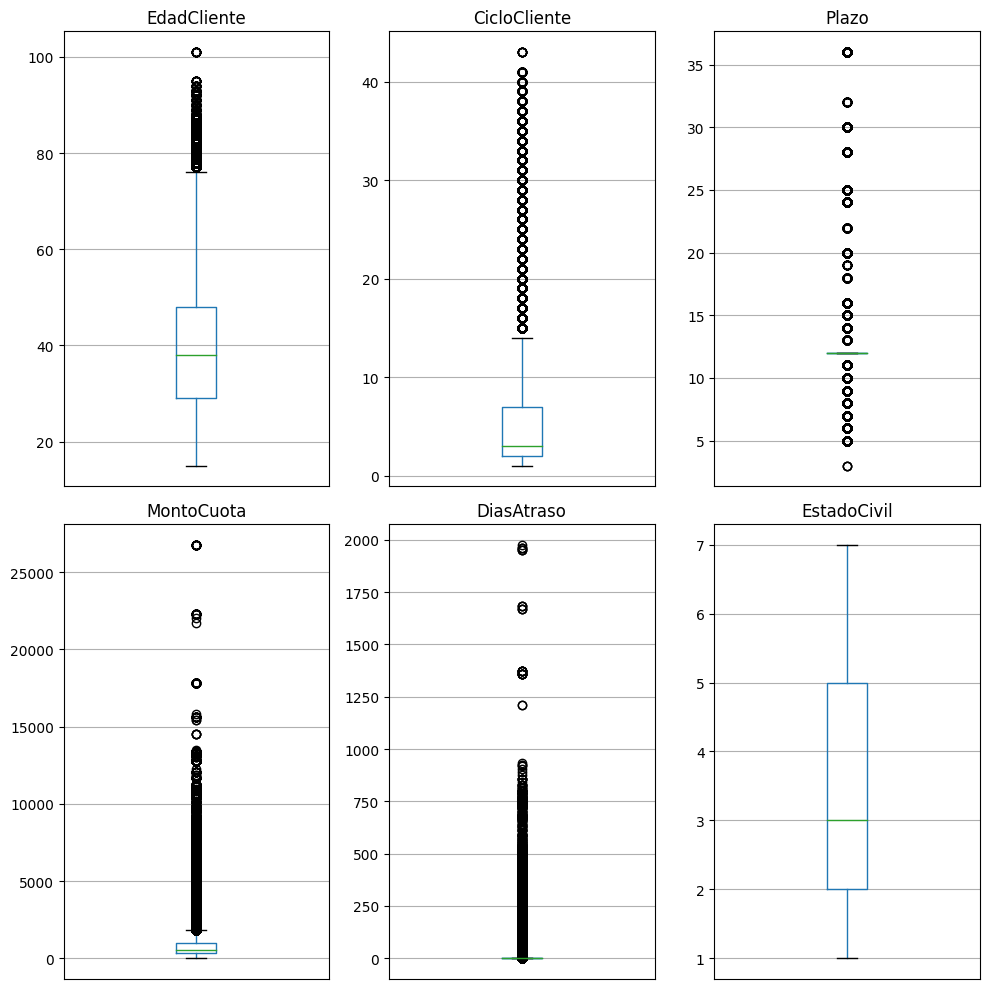

In [21]:
# graficamos para revisar valores atipicos de las primeras 6 variables numericas
fig, axes = plt.subplots(2, 3, figsize=(10, 10))  # Definimos una ventana de 3x3 nichos para incluir en cada uno de ellos un gráfico.

# Iterar sobre las columnas y generar un gráfico de caja para cada una
for k, ax in zip(range(0, 6), axes.flatten()):  # Usamos zip para iterar sobre los ejes y los índices
    dfnum.boxplot(column=dfnum.columns[k], ax=ax)  # Generar el gráfico de caja para la columna actual
    ax.set_title(dfnum.columns[k])  # Establecer el título del gráfico
    ax.set_xticks([])  # Eliminar las etiquetas del eje x para mayor claridad

plt.tight_layout()  # Ajustar el diseño para evitar superposiciones
plt.show()

In [22]:
# Determinamos los limintes de la variable EdadCliente

lower_limit, upper_limit = find_limits(dfnum,"EdadCliente",3)

In [23]:
# Conservemos las observaciones cuyo valor sea mayor o igual a (ge) el límite inferior:
inliner = dfnum["EdadCliente"].ge(lower_limit)
dfnum = dfnum.loc[inliner]

In [24]:
# Retenemos las observaciones cuyo valor sea menor o igual a (le) el límite superior:
inliner = dfnum["EdadCliente"].le(upper_limit)

dfnum = dfnum.loc[inliner]

In [25]:
trimmer = OutlierTrimmer(variables=["EdadCliente","CicloCliente","DiasAtraso"],
                         capping_method="iqr",
                         tail="both",
                         fold=1.5,)

In [26]:
trimmer.fit(dfnum)

OutlierTrimmer(capping_method='iqr', fold=1.5, tail='both',
               variables=['EdadCliente', 'CicloCliente', 'DiasAtraso'])

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


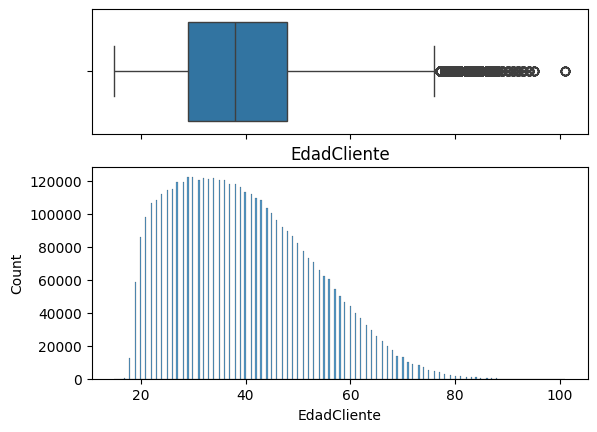

In [27]:
# Se muestra la distribucion de la variable EdadCliente
plot_boxplot_hist(dfnum,"EdadCliente")

In [28]:
dftransf = trimmer.transform(dfnum)

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


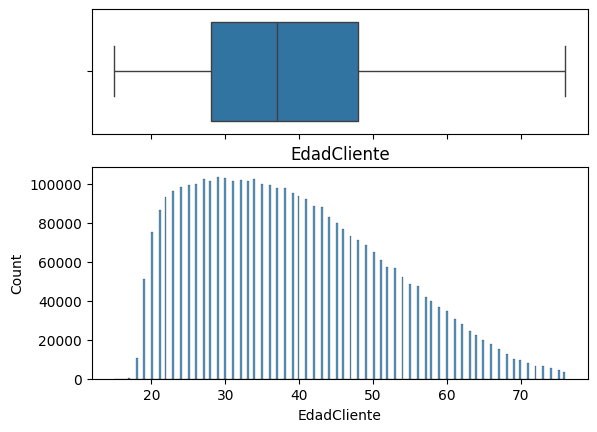

In [29]:
# Se muestra la distribucion de la variable EdadCliente
plot_boxplot_hist(dftransf,"EdadCliente")

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


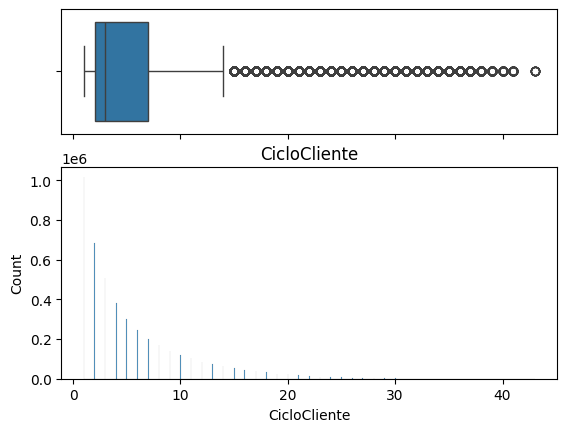

In [30]:
# Se muestra la distribucion de la variable CicloCliente
plot_boxplot_hist(dfnum,"CicloCliente")

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


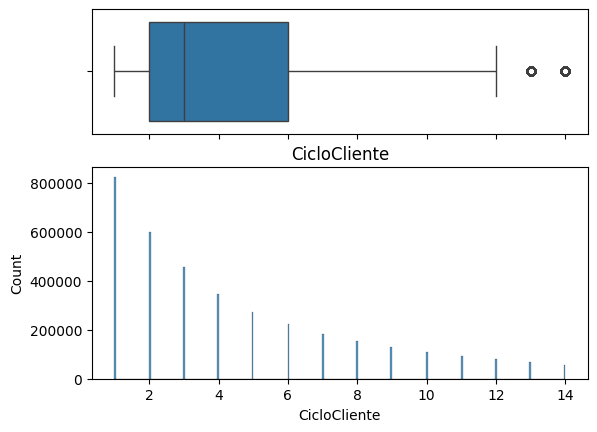

In [31]:
# Se muestra la distribucion de la variable EdadCliente
plot_boxplot_hist(dftransf,"CicloCliente")

In [35]:
newgpdf = dftransf.copy()
newgpdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3606092 entries, 0 to 4382213
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   EdadCliente     int64  
 1   CicloCliente    int64  
 2   Plazo           int64  
 3   MontoCuota      float64
 4   DiasAtraso      float64
 5   EstadoCivil     int64  
 6   IdCliente       int64  
 7   NumeroCredito   int64  
 8   EstatusCredito  object 
 9   Escolaridad     object 
dtypes: float64(2), int64(6), object(2)
memory usage: 302.6+ MB


### Avance 2

Para la generación de nuevas características en este contexto de análisis de comportamiento de clientes de créditos grupales, se puede considerar varias estrategias para crear variables adicionales que capturen aspectos relevantes del comportamiento de pago de los clientes.


Este siguiente código creará una nueva columna llamada 'HistorialPagos' que contiene la cantidad total de pagos realizados por cada cliente. Esto dará una visión general del historial de pagos de cada cliente, lo que podría ser útil para el análisis de comportamiento de pago y la gestión de cobranza

In [37]:
# Agregamos una columna que nos indique los creditos pagados

# Convertimos las columnas de fechas a tipo datetime
#gpdf['FechaDesembolso'] = pd.to_datetime(gpdf['FechaDesembolso'])
#gpdf['FechaVencimiento'] = pd.to_datetime(gpdf['FechaVencimiento'])
#gpdf['FechaCancelacion'] = pd.to_datetime(gpdf['FechaCancelacion'])

# Filtramos los creditos que han sido pagados (asumiendo que 'PAGADO' es el estado de un credito pagado)
pagados = newgpdf[newgpdf['EstatusCredito'] == 'CAN']

# Calculamos el historial de créditos pagados contando el número de creditos pagados por cliente
historial_pagos =pagados.groupby("IdCliente").NumeroCredito.nunique().reset_index(name='HistorialPagos')

# Unimos el historial de pagos con el DataFrame original
newgpdf = pd.merge(newgpdf, historial_pagos, on=('IdCliente'), how='left')

# Mostramos el DataFrame con la nueva variable 'HistorialPagos'
print(newgpdf[['IdCliente', 'HistorialPagos']].head())

   IdCliente  HistorialPagos
0        261             2.0
1      30654             2.0
2        262             2.0
3        261             2.0
4      30654             2.0


In [69]:
newgpdf.fillna(0, inplace=True)

In [ ]:
# Seleccion de caracteristicas
#features = ['EdadCliente', 'Genero', 'CicloCliente','Plazo', 'MontoCredito', 'MontoCapital', 'SaldoCapital', 'MontoCuota','DiasAtraso','EstadoCivil','EstatusCredito', 'Escolaridad','HistorialPagos']


In [38]:
#newgpdf = gpdf[features]
newgpdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3606092 entries, 0 to 3606091
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   EdadCliente     int64  
 1   CicloCliente    int64  
 2   Plazo           int64  
 3   MontoCuota      float64
 4   DiasAtraso      float64
 5   EstadoCivil     int64  
 6   IdCliente       int64  
 7   NumeroCredito   int64  
 8   EstatusCredito  object 
 9   Escolaridad     object 
 10  HistorialPagos  float64
dtypes: float64(3), int64(6), object(2)
memory usage: 302.6+ MB


In [54]:
 num_variables = ['EdadCliente', 'CicloCliente', 'Plazo', 'MontoCuota', 'DiasAtraso','EstadoCivil', 'IdCliente', 'NumeroCredito','HistorialPagos']
 cat_variables = ['EstatusCredito', 'Escolaridad']

In [70]:
# solo variables numerica
x_num = newgpdf[num_variables]

#### Preprocesamiento y creacion de pipeline

In [71]:
# fase de Escalamiento y normalizacion
num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])


In [72]:
# fase de Codificacion de categorias
cat_pipeline = Pipeline([
    ('encoder', OneHotEncoder())
])

In [73]:
# pipeline con metodos de preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_variables),
        ('cat', cat_pipeline, cat_variables)
    ])

#### Correlación

In [74]:
# Calcular la matriz de correlación
correlation_matrix = x_num.corr()

# visualizar la matriz de correlación
print("Matriz de correlación en var numericas:")
print(correlation_matrix)

# características más correlacionadas con umbral del .5
threshold = 0.5
highly_correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated_features.add(colname)

print("\nCaracterísticas correlacionadas:")
print(highly_correlated_features)

Matriz de correlación en var numericas:
                EdadCliente  CicloCliente     Plazo  MontoCuota  DiasAtraso  \
EdadCliente        1.000000      0.179720  0.048250    0.078064    0.017433   
CicloCliente       0.179720      1.000000  0.001242    0.446171   -0.019318   
Plazo              0.048250      0.001242  1.000000    0.019048   -0.018736   
MontoCuota         0.078064      0.446171  0.019048    1.000000   -0.018627   
DiasAtraso         0.017433     -0.019318 -0.018736   -0.018627    1.000000   
EstadoCivil       -0.060520      0.034170 -0.002272    0.012116   -0.032988   
IdCliente         -0.168628     -0.184701 -0.456121   -0.052949    0.033780   
NumeroCredito      0.013970      0.018377 -0.229583   -0.002094    0.095325   
HistorialPagos     0.153953      0.653004  0.059899    0.305344   -0.056462   

                EstadoCivil  IdCliente  NumeroCredito  HistorialPagos  
EdadCliente       -0.060520  -0.168628       0.013970        0.153953  
CicloCliente       0.0341

In [75]:
#Para identificar correlación
correlation_matrix = x_num.corr(numeric_only=True)

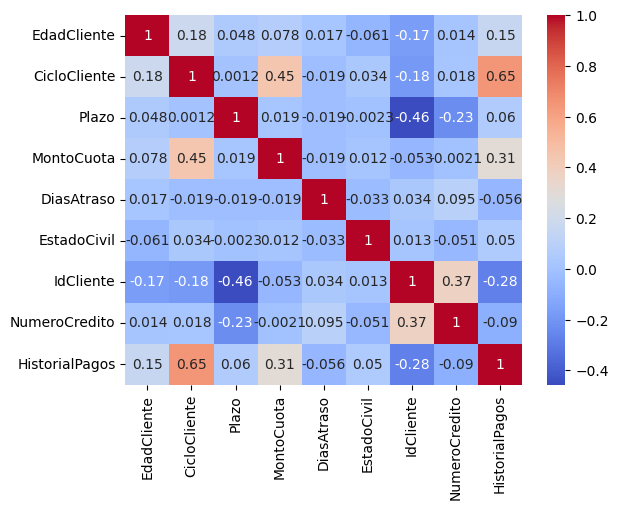

In [76]:

# Mapa de Correlacion
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

#### Umbral de Varianza

In [77]:

# Aplicar umbral de varianza con threshold de .1
threshold = 0.1
selector = VarianceThreshold(threshold=threshold)
X_selected = selector.fit_transform(x_num)

# Obtener los nombres de las características seleccionadas
selected_features = x_num.columns[selector.get_support()]

# Mostrar las características seleccionadas
print("Características seleccionadas con varianza superior al umbral:")
print(selected_features)

Características seleccionadas con varianza superior al umbral:
Index(['EdadCliente', 'CicloCliente', 'Plazo', 'MontoCuota', 'DiasAtraso',
       'EstadoCivil', 'IdCliente', 'NumeroCredito', 'HistorialPagos'],
      dtype='object')


#### PCA

In [78]:
print(newgpdf.Escolaridad.value_counts())
print(newgpdf.EstatusCredito.value_counts())

Escolaridad
1A    1077711
2B     687468
7B     409614
4      402613
8A     396048
2A     260640
7A     174413
5       76671
8B      48762
1B      34356
1       29777
8C       4367
3        2558
6        1094
Name: count, dtype: int64
EstatusCredito
CAN    3570731
CAI      35361
Name: count, dtype: int64


In [79]:
pca_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=2))
])


In [80]:
newgpdf.isnull().values.any()

False

In [82]:
principal_components = pca_pipeline.fit_transform(newgpdf)

In [83]:
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

In [84]:
# Exploración de la varianza
print("Varianza explicada por cada componente principal:")
print(pca_pipeline.named_steps['pca'].explained_variance_ratio_)



Varianza explicada por cada componente principal:
[0.22405893 0.16199039]


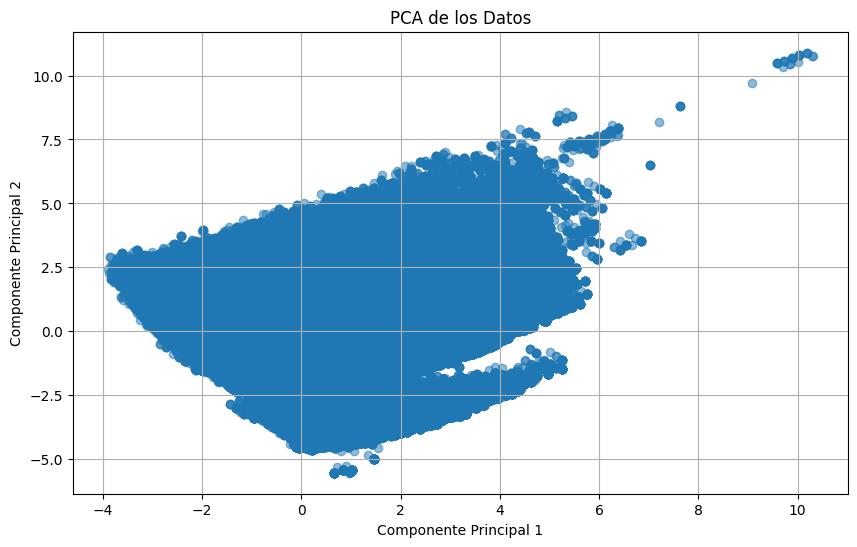

In [85]:
# plot
plt.figure(figsize=(10, 6))
plt.scatter(principal_df['PC1'], principal_df['PC2'], alpha=0.5)
plt.title('PCA de los Datos')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.show()

#### Generacion de nuevas caracteristicas con LLama3

La idea detras de generar conversaciones y acciones, es poder entrenar el modelo llama3 con un fine tune especifico a nuestras situacciones y acciones. Los datos se generan sintenticamente por un modelo LLM y los resultados son evaluados por expertos en el area.

In [ ]:
!pip install transformers

In [ ]:
!pip install accelerate

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
import transformers
import torch

model_id = "meta-llama/Meta-Llama-3-8B"

text_generator = transformers.pipeline(
    "text-generation", model=model_id, model_kwargs={"torch_dtype": torch.bfloat16}, device_map="auto"
)
template = "context: genera json con las posibles acciones:cobrar pago, resolver dudas, reportar pago. \nconversacion: {conversation}\n Accion: {action}\n"

generated_data = text_generator(template, max_length=50, do_sample=True, temperature=0.7, top_k=50)

# Print the generated data
print(generated_data[0]['generated_text'])

ImportError: Using `low_cpu_mem_usage=True` or a `device_map` requires Accelerate: `pip install accelerate`